<a href="https://colab.research.google.com/github/PavelNikishin/Airflow-for-analyst/blob/main/Project_work_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Настройка Airflow

Для начала вам необходимо выполнить ряд команд чтобы настроить окружение для дальнейшей работы, это позволит первое время не заниматься настройкой среды исполнения, а сразу начать писать код и работать с Airflow.

In [ ]:
%%capture
# Установка Airflow
#!pip install apache-airflow==2.1.4
!pip install "apache-airflow[telegram]==2.1.4" --constraint "https://raw.githubusercontent.com/apache/airflow/constraints-2.1.4/constraints-3.7.txt"

# Инициализация базы данных
!airflow db init

!pip install pyngrok

# Создадим необходимые папки
!mkdir /root/airflow/dags
!touch /root/airflow/dags/dag.py

In [ ]:
# Включим веб-сервер
!airflow webserver -p 18273 -D

# Создадим пользователя Airflow
!airflow users create \
          --username admin \
          --firstname admin \
          --lastname admin \
          --role Admin \
          --email admin@example.org \
          -p 12345

# Запуск шедулера
!airflow scheduler -D

#ngrok authtoken <YOUR TOKEN> # найти его можно https://dashboard.ngrok.com/get-started/setup 

!nohup ngrok http 18273 > /dev/null &

После запуска команды выше, перейдите по адресу в ngrok и подождите  пока появится DAG с именем dag

Измените путь до базы данных SQLite /content/example.db

Скриншот:

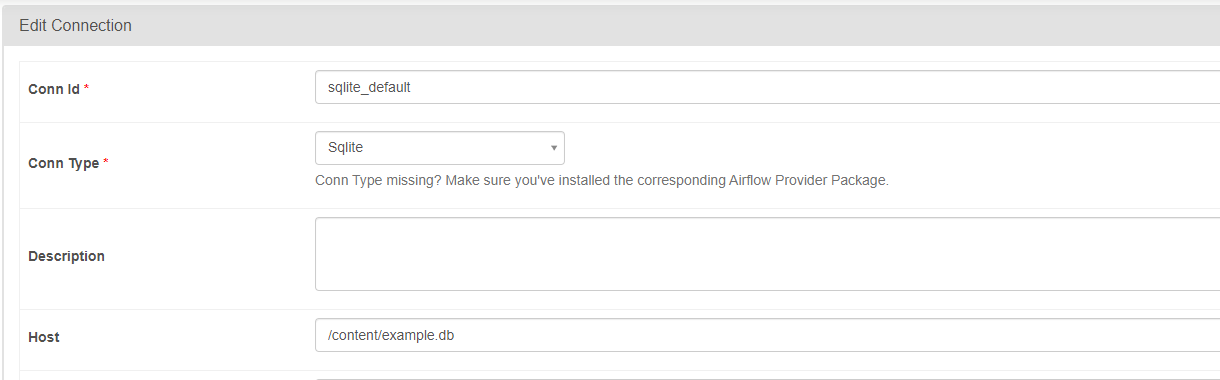

In [ ]:
# Решение на разработку

from airflow import DAG
from datetime import timedelta
from airflow.utils.dates import days_ago
from airflow.operators.python import PythonOperator
from airflow.providers.sqlite.operators.sqlite import SqliteOperator
from datetime import datetime

import pandas as pd
import sqlite3
import requests
import io

CONN = sqlite3.connect('/content/example.db')


# Создаем даг который создаст таблицу, запускаем один раз
dag_create_table= DAG(
    dag_id='dag_create_table',
    schedule_interval='@once',
    start_date=datetime(2022, 1, 26),
)

# Задача для создания таблицы в sqlite базе данных
create_table_data = SqliteOperator(
    task_id='create_table_data',
    sql="""CREATE TABLE join_data(
      currency TEXT, 
      value INTEGER, 
      date DATE, 
      rate FLOAT
      )
    """,
    dag=dag_create_table,
)

# Даг который скачивает и объединяет данные
dag = DAG('dag', 
          start_date=datetime(2021, 1, 1),
          end_date=datetime(2021, 1, 4), 
          max_active_runs=1)

def extract_currency(date, **kwargs):
  url = f'https://api.exchangerate.host/timeseries?start_date={date}&end_date={date}&base=EUR&symbols=USD&format=csv'
  response = requests.get(url).content
  data = pd.read_csv(io.StringIO(response.decode('utf-8')))

  kwargs['ti'].xcom_push(key='return_value', value=data['rate'].values[0])


def insert_to_db(data, table_name, conn):
  data.to_sql(table_name, conn, if_exists='append', index=False)

def extract_data(date, conn):
  url = f'https://raw.githubusercontent.com/dm-novikov/stepik_airflow_course/main/data_new/{date}.csv'
  data = pd.read_csv(url,index_col=False)

  insert_to_db(data, 'data', conn)


read_csv_file_1 = PythonOperator(task_id='read_currency', 
                      python_callable=extract_currency,
                      op_kwargs={'date': '{{ ds }}'}, 
                      dag=dag)

  
read_csv_file_2 = PythonOperator(task_id='read_data', 
                      python_callable=extract_data,
                      op_kwargs={'date': '{{ ds }}', 'conn': CONN},
                      dag=dag)


join_data= SqliteOperator(
    task_id='join_data',
    sql=''' INSERT INTO join_data
            SELECT currency, value, date, ''' + "{{ ti.xcom_pull(key='return_value').replace(',','.') }}" + '''
            FROM data
            WHERE date=''' + '\'' + '{{ ds }}' + '\'',
    dag=dag
)

[read_csv_file_1, read_csv_file_2] >> join_data

In [ ]:
# чтобы првоерить решение можете обратиться к вашей базе данных таким образом
%reload_ext sql
%config SqlMagic.feedback=False 
%config SqlMagic.autopandas=True
%sql sqlite:////content/example.db
%sql select * from join_data

 * sqlite:////content/example.db


,currency,value,date,rate
0,EUR,38,2021-01-01,1.217582
1,EUR,65,2021-01-01,1.217582
2,EUR,74,2021-01-01,1.217582
3,EUR,42,2021-01-01,1.217582
4,EUR,23,2021-01-01,1.217582
5,EUR,48,2021-01-01,1.217582
6,EUR,86,2021-01-01,1.217582
7,EUR,74,2021-01-01,1.217582
8,EUR,24,2021-01-01,1.217582
9,EUR,27,2021-01-02,1.213500
